<a href="https://colab.research.google.com/github/RuzbehAmrolia/covid_vaccine_tweets/blob/main/Twitter_Model_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tweet-preprocessor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Embedding,Bidirectional,LSTM,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import preprocessor as p
from sklearn.naive_bayes import MultinomialNB
import re
import os
from textblob import TextBlob

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
wn = nltk.WordNetLemmatizer()

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')
stopwords = set(STOPWORDS)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
from keras.models import model_from_json


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vaccination_all_tweets.csv to vaccination_all_tweets.csv


In [ ]:
df=pd.read_csv('vaccination_all_tweets.csv')
df.head()

user_location              date  ... favorites is_retweet
0  La Crescenta-Montrose, CA   2020-12-20 6:06  ...         0      False
1          San Francisco, CA  2020-12-13 16:27  ...         1      False
2                   Your Bed  2020-12-12 20:33  ...         0      False
3     Vancouver, BC - Canada  2020-12-12 20:23  ...      2129      False
4                        NaN  2020-12-12 20:17  ...         0      False

[5 rows x 7 columns]

In [ ]:
#df.drop(['id', 'user_name', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'source'], axis=1, inplace = True)
df.drop_duplicates(subset = "text", keep = "first", inplace = True)
df.dropna()
df.head()

user_location              date  ... favorites is_retweet
0  La Crescenta-Montrose, CA   2020-12-20 6:06  ...         0      False
1          San Francisco, CA  2020-12-13 16:27  ...         1      False
2                   Your Bed  2020-12-12 20:33  ...         0      False
3     Vancouver, BC - Canada  2020-12-12 20:23  ...      2129      False
4                        NaN  2020-12-12 20:17  ...         0      False

[5 rows x 7 columns]

In [ ]:
df.drop_duplicates(subset = "text", keep = "first",inplace = True,ignore_index = True) #Removing duplicates

In [ ]:
tweet_list = []
for x in df["text"]:
    tweet_list.append(p.clean(x)) #Cleaning tweets (Removes URLs, Hashtags, Mentions, Reserved Words (RT,FAV) Emojis, Smileys) and appending to a list
    
tweet_list = [re.sub('[^a-zA-Z]', ' ',i) for i in tweet_list] #Removing punctuatuons

In [ ]:
print("----Before----")
print(df["text"][3])

print("----After----")
print(tweet_list[3])

----Before----
Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
----After----
Facts are immutable  Senator  even when you re not ethically sturdy enough to acknowledge them      You were born i


In [ ]:
clean_tweets = []
for tweet in tweet_list: 
  for word in set(stopwords):
    token = " "+word+" "
    tweet = tweet.replace(token, " ")
  clean_tweets.append(tweet)


In [ ]:
stemmed = []
lemmen = []
for word in clean_tweets:
    lemmen.append(lemmatizer.lemmatize(word))
  

In [ ]:
lemmenn = []
for word in clean_tweets:
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(word)) 
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      # if there is no available tag, append the token as is
      lemmatized_sentence.append(word)
    else:        
      # else use the tag to lemmatize the token
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)
  lemmenn.append(lemmatized_sentence)


In [ ]:
i=2
print(clean_tweets[i])
print(lemmenn[i])

Russian vaccine created last    years
Russian vaccine create last year


In [ ]:
df["Processed"] = lemmenn
df.head()

user_location  ...                                          Processed
0  La Crescenta-Montrose, CA  ...    Same folk say daikon paste treat cytokine storm
1          San Francisco, CA  ...  While world wrong side history year hopefully ...
2                   Your Bed  ...                   Russian vaccine create last year
3     Vancouver, BC - Canada  ...  Facts immutable Senator even re ethically stur...
4                        NaN  ...                               Explain need vaccine

[5 rows x 8 columns]

In [ ]:
df.Processed = df.Processed.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

user_location  ...                                          Processed
0  La Crescenta-Montrose, CA  ...        Same folk daikon paste treat cytokine storm
1          San Francisco, CA  ...  While world wrong side history year hopefully ...
2                   Your Bed  ...                   Russian vaccine create last year
3     Vancouver, BC - Canada  ...  Facts immutable Senator even ethically sturdy ...
4                        NaN  ...                               Explain need vaccine

[5 rows x 8 columns]

In [ ]:
tokenized_tweet = df['Processed'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Same, folk, daikon, paste, treat, cytokine, s...
1    [While, world, wrong, side, history, year, hop...
2               [Russian, vaccine, create, last, year]
3    [Facts, immutable, Senator, even, ethically, s...
4                             [Explain, need, vaccine]
Name: Processed, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vector = TfidfVectorizer(ngram_range=(1,1), max_features=150).fit(df["Processed"]) 
trans = vector.transform(df["Processed"])  # Transforming the vectorizer
df_vect=pd.DataFrame(trans.toarray(), columns=vector.get_feature_names()) # Converting to DataFrame

df_vect.head(10)

administer  after  alone  already  ...  work     world      year  yesterday
0         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
1         0.0    0.0    0.0      0.0  ...   0.0  0.534019  0.530362        0.0
2         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.547700        0.0
3         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
4         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
5         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
6         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
7         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
8         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0
9         0.0    0.0    0.0      0.0  ...   0.0  0.000000  0.000000        0.0

[10 rows x 150 columns]

In [ ]:
pol = []

for tweet in df["Processed"]:
    blob = TextBlob(tweet)
    pol.append(blob.sentiment.polarity)
df['Polarity']=pol

In [ ]:
positive ,negative, neutral = 0,0,0

for polar in df["Polarity"]:
    if polar > 0:
        positive += 1
    elif polar < 0:
        negative += 1
    else:
        neutral += 1
        
pol_list = []

for x in pol:
    if x>0:
        pol_list.append("Positive")
    elif x<0:
        pol_list.append("Negative")
    else:
        pol_list.append("Neutral")
        
df["Sentiment"] = pol_list

Neutral     37130
Positive    24693
Negative     7798
Name: Sentiment, dtype: int64


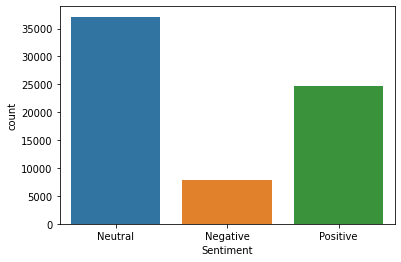

In [ ]:
print(df.Sentiment.value_counts())
sns.countplot(x='Sentiment', data = df);

In [ ]:
label = list(df["Sentiment"].unique())
labl = []
labl.append(label[0])
labl.append(label[2])
labl.append(label[1])
values = df["Sentiment"].value_counts()
label = labl
label

['Neutral', 'Positive', 'Negative']

In [ ]:
sentences = list(df.Processed)
labels = df.Sentiment.tolist()

In [ ]:
fig = go.Figure(data=[go.Pie(labels=labl, values=values, hole=.5)])
fig.update_layout(
    title_text="Twitter Tweets Sentiments",
    annotations=[dict(text='Emotions', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.update_layout(
    autosize=False)
fig.show()

In [ ]:
#Converting any float values in the processed tweets into string

ctr2 = 0 
for x in sentences:
    if type(x) == float:
        ctr2 += 1
        sentences[sentences.index(x)] = "nan"

In [ ]:
from google.colab import files
import pandas as pd
df.to_csv('vaccination_all_tweets.csv')
files.download('vaccination_all_tweets.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
embedding_dim = 150 
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .75

In [ ]:
train_size = round(training_portion * len(sentences)) 

train_sentences = sentences[:train_size]
train_labels = np.array(labels[:train_size])

validation_sentences = sentences[train_size:]
validation_labels = np.array(labels[train_size:])


In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = train_labels.reshape(len(train_labels), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = validation_labels.reshape(len(validation_labels), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [ ]:
print(onehot_encoder.categories_)

vocab_size = len(set(" ".join(train_sentences).split()))
vocab_size

[array(['Negative', 'Neutral', 'Positive'], dtype='<U8')]


27920

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = np.array(pad_sequences(train_sequences,maxlen=max_length,truncating=trunc_type,padding=padding_type))

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))

print(len(validation_sequences))
print(validation_padded.shape)

17405
(17405, 200)


In [ ]:
model = tf.keras.Sequential([
    
    Embedding(vocab_size,embedding_dim,input_length = max_length),
    Bidirectional(LSTM(250)),
    Dropout(0.5),
    BatchNormalization(),
    Dropout(0.5),
    Flatten(),
    Dense(6,activation='tanh'),
    Dropout(0.5),
    Dense(3,activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 150)          4188000   
_________________________________________________________________
bidirectional (Bidirectional (None, 500)               802000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=9e-4),loss='categorical_crossentropy',metrics=['accuracy'])

#Training the Model


history = model.fit(train_padded,
                    onehot_encoded_train,
                    epochs=7,
                    validation_data=(validation_padded,onehot_encoded_val))

Epoch 1/7
1632/1632 [==============================] - 157s 75ms/step - loss: 0.7109 - accuracy: 0.7430 - val_loss: 0.1667 - val_accuracy: 0.9605
Epoch 2/7
1632/1632 [==============================] - 121s 74ms/step - loss: 0.2513 - accuracy: 0.9271 - val_loss: 0.1280 - val_accuracy: 0.9705
Epoch 3/7
1632/1632 [==============================] - 121s 74ms/step - loss: 0.2087 - accuracy: 0.9418 - val_loss: 0.1229 - val_accuracy: 0.9718
Epoch 4/7
1632/1632 [==============================] - 121s 74ms/step - loss: 0.1944 - accuracy: 0.9441 - val_loss: 0.1263 - val_accuracy: 0.9724
Epoch 5/7
1632/1632 [==============================] - 121s 74ms/step - loss: 0.1799 - accuracy: 0.9485 - val_loss: 0.1114 - val_accuracy: 0.9789
Epoch 6/7
1632/1632 [==============================] - 121s 74ms/step - loss: 0.1715 - accuracy: 0.9520 - val_loss: 0.1230 - val_accuracy: 0.9752
Epoch 7/7
1632/1632 [==============================] - 121s 74ms/step - loss: 0.1624 - accuracy: 0.9553 - val_loss: 0.1154 -

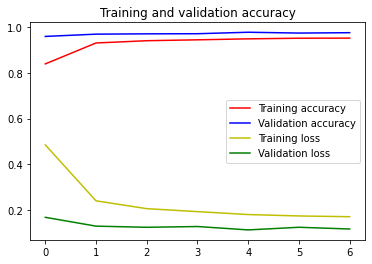

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig('plot.png')

In [ ]:
scores = model.evaluate(validation_padded,
                    onehot_encoded_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 97.69%


**SAVING MODEL TO DRIVE**

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/Models/model_weights.h5")
print("Saved model to drive")

Saved model to drive


**LOADING SAVED MODEL FROM DRIVE**

In [ ]:
# load json and create model
json_file = open('/content/gdrive/MyDrive/Models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/MyDrive/Models/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer = tf.keras.optimizers.Adam(lr=9e-4),loss='categorical_crossentropy',metrics=['accuracy'])
scores = loaded_model.evaluate(train_padded,
                    onehot_encoded_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.60%


**PREDICTING**

In [ ]:
import preprocessor as p

# Tweets for testing the model's actual accuracy

test_tweet = df.text

test_tweet_clean = []

for line in test_tweet:
    test_tweet_clean.append(p.clean(line))


for i,line in enumerate(test_tweet_clean):             
        for word in set(stopwords):
            token = " "+word+" "
            line = line.replace(token, " ")
        test_tweet_clean[i] = line



a = tokenizer.texts_to_sequences(test_tweet_clean)
a1 = np.array(pad_sequences(a, maxlen = max_length, truncating = trunc_type, padding = padding_type))

In [ ]:
predictions = loaded_model.predict(a1)

#Displaying results

df['new_sentiment'] = ' '
for j,k in enumerate(predictions):
    m = max(k)
    print(j+1,") ",test_tweet_clean[j])
    if k.tolist().index(m) == 0:
        df['new_sentiment'][j] = 'negative'
    elif k.tolist().index(m) == 1:
        df['new_sentiment'][j] = 'neutral'
    else:
        df['new_sentiment'][j] = 'positive'


1 )  Same folks said daikon paste treat cytokine storm
2 )  While world wrong side history year, hopefully, biggest vaccination effort ev
3 )  Russian vaccine created last -4 years
4 )  Facts immutable, Senator, even ethically sturdy enough acknowledge them. (1) You born i
5 )  Explain need vaccine
6 )  Does anyone useful advice/guidance whether COVID vaccine safe whilst breastfeeding?
7 )  it bit sad claim fame success patriotic competition USA, Canada, UK and
8 )  There many bright days best . winning
9 )  Covid vaccine; You getting it?
10 )  States will start getting Monday, says
11 )  while deaths closing mark... millions people wait !-The first U
12 )  Best wishes US
13 )  The agency released new information health care providers patients US shipped millions d
14 )  For women healthcare providers asking safety the
15 )  "Expect sites across states receive vaccine Monday, another sites Tuesday," said offic
16 )  Trump announces rollout 'in less hours'The first Americans will vaccin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Streaming output truncated to the last 5000 lines.
64622 )  Vaccine down!
64623 )  vaccine nd dose via . The world will now feel wrath!
64624 )  Oh, happy day... one down, one go! Im filled happiness well endless gratitude science t
64625 )  Yay! First dose vaccine done. One month second, -2 months full coat armor.
64626 )  After months demand outstripping supply, vaccines readily available, the
64627 )  Got first dose Moderna. Second dose set /20!
64628 )  Anyone checking recipients, blood clots? Just balance scary media stories, abou
64629 )  Got vaccinated nature center places!
64630 )  Shot one complete! What emotional sense relief.
64631 )  Just got second dose . Please hate ; didnt really want vaccine . But w/ cancer, immune s
64632 )  PCI security compliance scanning entire cloud platform
64633 )  Just now administered first dose . So far alls good
64634 )  looking my
64635 )  Fully vaccinated
64636 )  I mean...
64637 )  Watch Dr. Joel Amidon, chief medical officer, Gail Carmich

In [ ]:
print(predictions)

[[1.0519284e-03 9.9829227e-01 6.5585744e-04]
 [9.4122505e-01 1.6022615e-02 4.2752273e-02]
 [1.0518671e-03 9.9829227e-01 6.5585051e-04]
 ...
 [1.0517961e-03 9.9829239e-01 6.5583811e-04]
 [1.0790154e-03 9.9825412e-01 6.6691288e-04]
 [6.0052238e-03 1.3238975e-03 9.9267089e-01]]


In [ ]:
df.Processed = df.Processed.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head(10000)

user_location              date  ... Sentiment new_sentiment
0     La Crescenta-Montrose, CA   2020-12-20 6:06  ...   Neutral       neutral
1             San Francisco, CA  2020-12-13 16:27  ...  Negative      negative
2                      Your Bed  2020-12-12 20:33  ...   Neutral       neutral
3        Vancouver, BC - Canada  2020-12-12 20:23  ...  Positive      positive
4                           NaN  2020-12-12 20:17  ...   Neutral       neutral
...                         ...               ...  ...       ...           ...
9995            Brussel, België    2021-2-18 7:40  ...  Positive       neutral
9996                        NaN    2021-2-18 7:34  ...  Negative      negative
9997                    Atlanta    2021-2-18 7:22  ...  Positive      positive
9998         Belly-of-the-Beast    2021-2-18 7:07  ...  Negative      negative
9999    Johanneburg, ZA, Africa    2021-2-18 7:04  ...   Neutral       neutral

[10000 rows x 11 columns]

In [ ]:
tokenized_tweet = df['Processed'].apply(lambda x: x.split())
tokenized_tweet.head()



0    [Same, folk, daikon, paste, treat, cytokine, s...
1    [While, world, wrong, side, history, year, hop...
2               [Russian, vaccine, create, last, year]
3    [Facts, immutable, Senator, even, ethically, s...
4                             [Explain, need, vaccine]
Name: Processed, dtype: object

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [same, folk, daikon, past, treat, cytokin, storm]
1    [while, world, wrong, side, histori, year, hop...
2                 [russian, vaccin, creat, last, year]
3    [fact, immut, senat, even, ethic, sturdi, enou...
4                              [explain, need, vaccin]
Name: Processed, dtype: object

In [ ]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['Processed']= tokenized_tweet
df.head()

user_location              date  ... Sentiment new_sentiment
0  La Crescenta-Montrose, CA   2020-12-20 6:06  ...   Neutral       neutral
1          San Francisco, CA  2020-12-13 16:27  ...  Negative      negative
2                   Your Bed  2020-12-12 20:33  ...   Neutral       neutral
3     Vancouver, BC - Canada  2020-12-12 20:23  ...  Positive      positive
4                        NaN  2020-12-12 20:17  ...   Neutral       neutral

[5 rows x 11 columns]

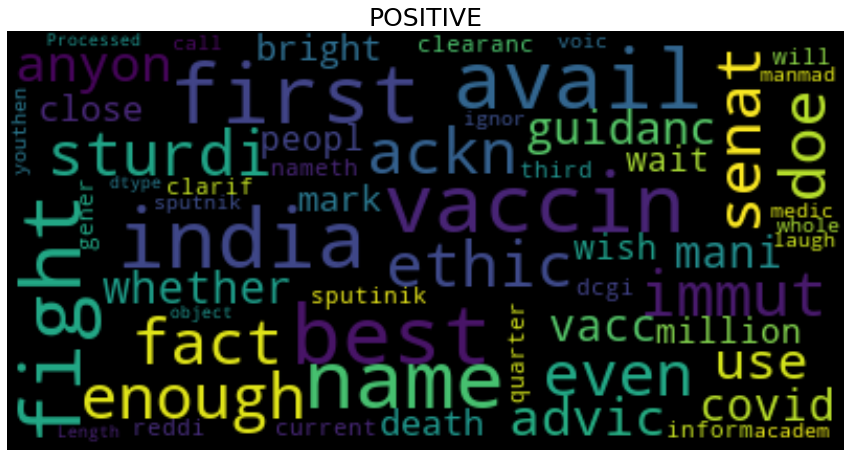

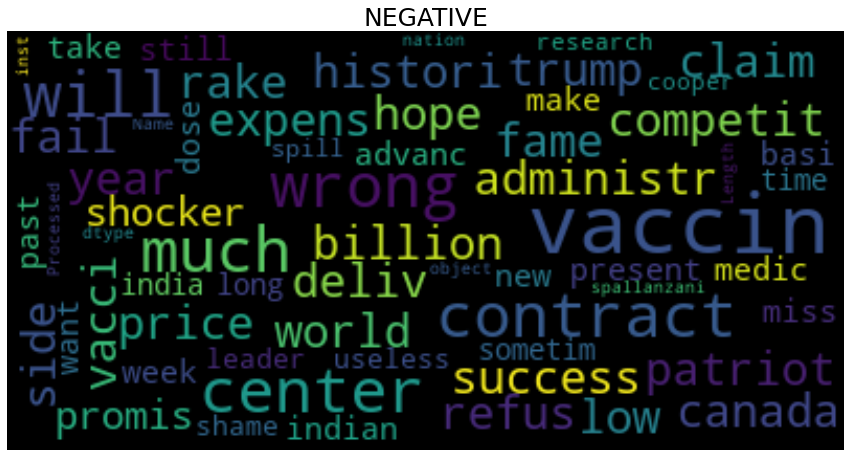

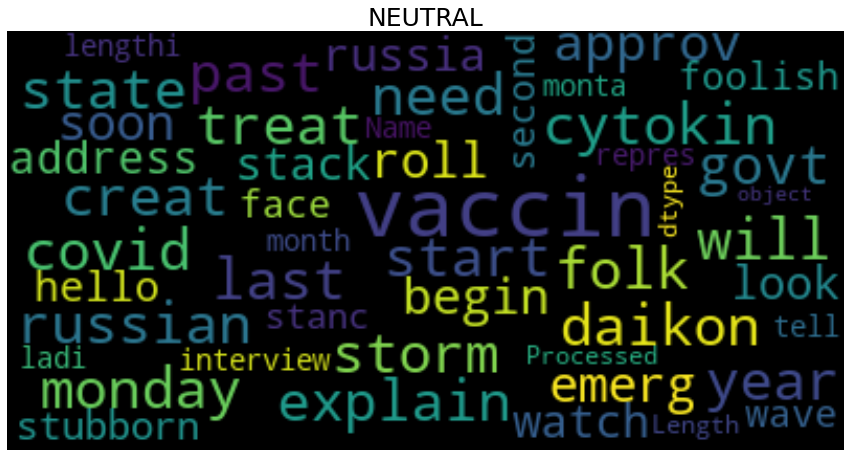

In [ ]:
def show_wordcloud(data , title = None):
    wordcloud = WordCloud(background_color='black',max_words=100,max_font_size=40, stopwords=set(STOPWORDS),collocations=False).generate(str(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.title(title, size = 25)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

pos = df['Processed'][df['new_sentiment'] == 'positive']
show_wordcloud(pos , 'POSITIVE')

neg = df['Processed'][df['new_sentiment']  == 'negative']
show_wordcloud(neg , 'NEGATIVE')

neutral = df['Processed'][df['new_sentiment']  == 'neutral']
show_wordcloud(neutral , 'NEUTRAL')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



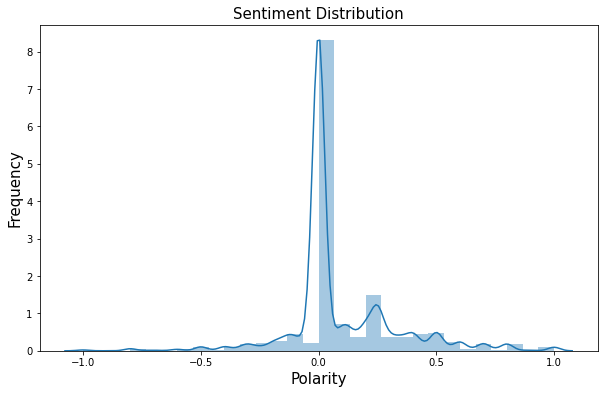

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(df['Polarity'], bins=30)
plt.title('Sentiment Distribution',size = 15)
plt.xlabel('Polarity',size = 15)
plt.ylabel('Frequency',size = 15)
plt.show();

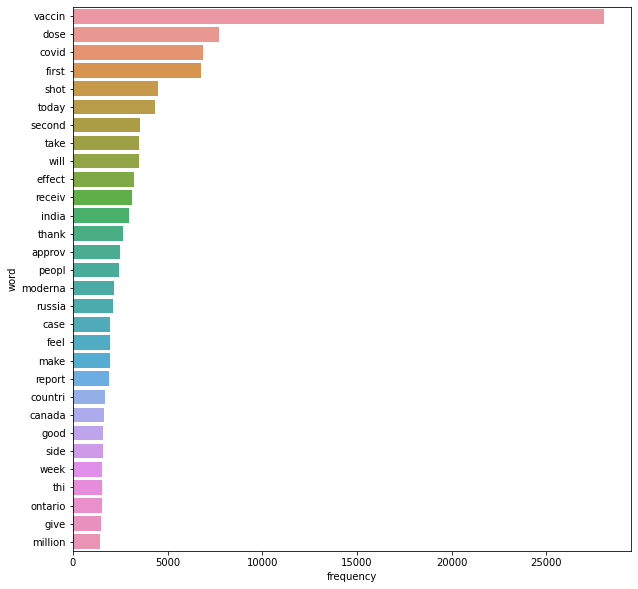

In [ ]:
from collections import Counter
words = []
words = [word for i in df.Processed for word in i.split()]
freq = Counter(words).most_common(30)
freq = pd.DataFrame(freq)
freq.columns = ['word', 'frequency']
freq.head()
plt.figure(figsize = (10, 10))
sns.barplot(y="word", x="frequency",data=freq);

In [ ]:
dic={}
for i in df['hashtags'].dropna().values:
    if i==np.nan:
        continue
    else:
        for j in i.strip('][').split(', ') :
            if j in dic:
                dic[j]+=1
            else:
                dic[j]=1
dic=dict(sorted(dic.items(), key=lambda item: item[1],reverse=True))

fig_bar=px.bar(x=list(dic.keys())[:10],y=list(dic.values())[:10],color=list(dic.keys())[:10],labels={'x':'Hashtag (#)','y':'Counts'})

fig_bar.show()



In [ ]:
df["user_location"] = df["user_location"].str.rsplit(', ').str[-1]
df["user_location"] = df["user_location"].replace(['CA','United States','NY','TX','Ohio','LA','NJ','New York City','NYC','OH','Los Angeles''Las Vegas'],'USA')
df["user_location"] = df["user_location"].replace(['india','mumbai','New Delhi','Bharat','Chennai','Delhi','patna','Hyderabad','Mumbai','Jammu And Kashmir'],'India')
df["user_location"] = df["user_location"].replace(['United Kingdom', 'London'],'UK')

In [ ]:
fig=px.bar(data_frame=df, x=df["user_location"].value_counts().values[0:20], y=df["user_location"].value_counts().index[0:20], orientation='h', 
           labels={'x':'No. of Tweets', 'y':'Location'}, color=df["user_location"].value_counts().index[0:20])
fig.update_layout(title="Top 15 Places with maximum tweets", xaxis_title='Number of Tweets', yaxis_title='', yaxis=dict(autorange="reversed"))
fig.show()

In [ ]:
hist2=px.histogram(data_frame=df,x='date',color='new_sentiment',marginal="rug")
hist2.update_xaxes(showgrid=False)
hist2.update_yaxes(showgrid=False)
hist2.show()